NLP Text Data Prediction using LSTM

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#load the dataset
df = tfds.load('imdb_reviews', as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE6QCBB/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE6QCBB/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteE6QCBB/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#seperating train and test
traindf, testdf = df['train'], df['test']

In [ ]:
#batching train and test, shuffling train
batch_size = 32
traindf = traindf.shuffle(10000)
traindf = traindf.batch(batch_size)
testdf = testdf.batch(batch_size)

In [ ]:
example, label = next(iter(traindf))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b"I just picked up the DVD release of this movie while on holiday in Norway where it has been released with English subtitles.<br /><br />The film is beautifully photographed and powerfully acted. The youngster portraying 'Frits' the lead character has an astonishingly open face which mirrors with painful accuracy the tragic events which unfold around him.<br /><br />Early on in the film we see that the father whom Frits loves so much has mental health problems and this is brought up when the brutal headmaster denies assaulting the boy and suggests it was his own father.<br /><br />The climactic scene where Frits refuses to show any respect to the headmaster; simply standing his ground and repeating 'Liar' as he is brutally assaulted in front of his classmates is a scene you are not likely to forget.<br /><br />The films only weak point is the rather clich\xc3\xa9d 'Flower Power' teacher who uses every 'friendly teacher' trick in the book. Other than this I feel sure that this i

# Model Architecture

In [ ]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(traindf.map(lambda text, _: text))
# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())
# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])
print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b"I just picked up the DVD release of this movie while on holiday in Norway where it has been released with English subtitles.<br /><br />The film is beautifully photographed and powerfully acted. The youngster portraying 'Frits' the lead character has an astonishingly open face which mirrors with painful accuracy the tragic events which unfold around him.<br /><br />Early on in the film we see that the father whom Frits loves so much has mental health problems and this is brought up when the brutal headmaster denies assaulting the boy and suggests it was his own father.<br /><br />The climactic scene where Frits refuses to show any respect to the headmaster; simply standing his ground and repeating 'Liar' as he is brutally assaulted in front of his classmates is a scene you are not likely to forget.<br /><br />The films only weak point is the rather clich\xc3\xa9d 'Flower Power' teacher who uses every 'friendly teacher' trick in the book. Other than this I feel sure that th

In [ ]:
#model building
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

In [ ]:
# Training the model and validating it on test set
history = model.fit(
    traindf,
    epochs=5,
    validation_data=testdf,)

Epoch 1/5
782/782 [==============================] - 213s 248ms/step - loss: 0.4723 - accuracy: 0.7608 - val_loss: 0.3421 - val_accuracy: 0.8416
Epoch 2/5
782/782 [==============================] - 138s 177ms/step - loss: 0.3044 - accuracy: 0.8745 - val_loss: 0.3652 - val_accuracy: 0.8189
Epoch 3/5
782/782 [==============================] - 123s 157ms/step - loss: 0.2209 - accuracy: 0.9110 - val_loss: 0.3678 - val_accuracy: 0.8080
Epoch 4/5
782/782 [==============================] - 118s 151ms/step - loss: 0.1679 - accuracy: 0.9361 - val_loss: 0.3485 - val_accuracy: 0.8568
Epoch 5/5
782/782 [==============================] - 115s 147ms/step - loss: 0.1176 - accuracy: 0.9570 - val_loss: 0.4045 - val_accuracy: 0.8633


In [ ]:
#training history
history_dict = history.history

In [ ]:
#separating the validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
print(acc)
print(val_acc)

[0.7607600092887878, 0.8745200037956238, 0.9110000133514404, 0.9361199736595154, 0.957040011882782]
[0.8416000008583069, 0.8189200162887573, 0.8080400228500366, 0.8568400144577026, 0.863319993019104]


In [ ]:
#separating the validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']
print(loss)
print(val_loss)

[0.4723491668701172, 0.30439844727516174, 0.22089238464832306, 0.16787226498126984, 0.11759309470653534]
[0.34212586283683777, 0.3651881515979767, 0.3677702844142914, 0.34854069352149963, 0.40454140305519104]


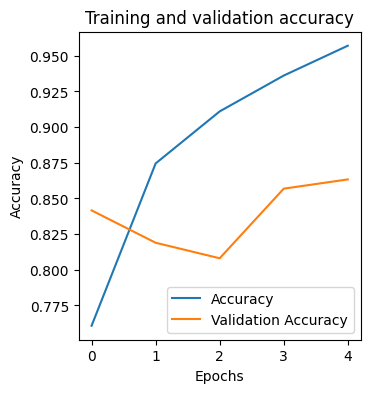

In [ ]:
#plotting accuracy
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

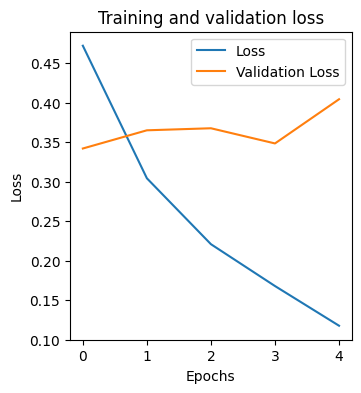

In [ ]:
#plotting loss
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

In [ ]:
#predicting
predictions = model.predict(testdf)
print(predictions[0])
if predictions[0] > 0:
  print('positive')
else:
  print('negative')

782/782 [==============================] - 38s 43ms/step
[2.6373863]
positive


In [ ]:
from sklearn.metrics import confusion_matrix
# Predict classes for the test set
predicted_classes = (predictions > 0).astype("int32")
# Convert test labels to binary (1 for positive, 0 for negative)
test_labels = np.concatenate([y for x, y in testdf], axis=0)
binary_test_labels = (test_labels > 0).astype("int32")
conf_matrix = confusion_matrix(binary_test_labels, predicted_classes)
conf_matrix

array([[11335,  1165],
       [ 2127, 10373]])

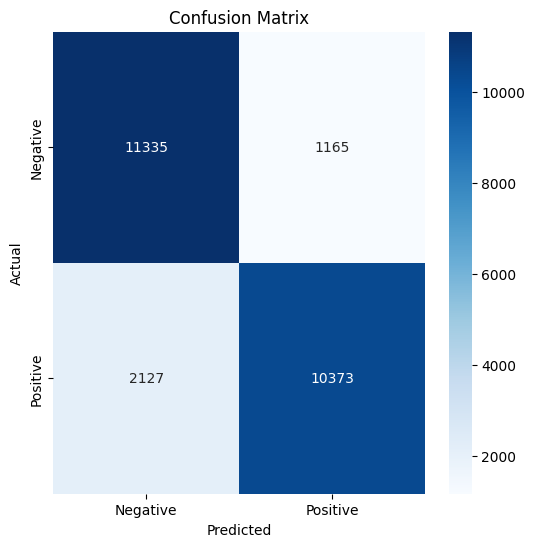

In [ ]:
# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()